In [14]:
'''Plots the phases of the moon from  given date range. Moon phases are calculted based on Astral package.
See https://astral.readthedocs.io/en/latest/index.html for further info.

moon.phase() Calculates the phase of the moon on the specified date.

    Args:
        date: The date to calculate the phase for. Dates are always in the UTC timezone.
              If not specified then today's date is used.

    Returns:
        A number designating the phase.

        ============  ==============
        0 .. 6.99     New moon
        7 .. 13.99    First quarter
        14 .. 20.99   Full moon
        21 .. 27.99   Last quarter
        ============  ==============

'''




from astropy.time import Time
#from astroplan import download_IERS_A 
import pandas as pd

from astropy.coordinates import EarthLocation
from astroplan import Observer,FixedTarget

from astroplan.plots import plot_airmass,plot_altitude
import astropy.units as u
from astropy.coordinates import SkyCoord
from astral import moon


import numpy as np
from pytz import common_timezones
import matplotlib.pyplot as plt
from datetime import datetime
import datetime
import pyorbital
import cv2
#import colorama
from colorama import Fore, Style
pd.set_option("display.max_rows", None, "display.max_columns", None)

%matplotlib inline

In [15]:
#Input information of source (RA and DEC)
#ra=str(input("Enter the Right Ascenscion(RA) of Source in 00h00m00s format i.e 139d31m24.765s or 20h42m30s: "))
#dec=str(input("Enter the Declination(DEC) of Source in 00d00m00s formati.e -12d05m43.99s or +40h22m50s: "))
#source_name=str(input("Enter the Name of the source in string format, ie Hydra A,Polaris,cent_A: "))
#print('you have entered Right Ascension of'+' '+ra,', Declination of' +' '+dec+' Frame set to ICRS')




In [16]:
#Specify paramenters
#Co-vis type input 'max' for maximum co-vis or 'sum' for sum of all co-vis 

ra='09d18m06s'
dec='-12d05m45s'
source_name='hydraA'




co_vis_type='sum' #'sum' or 'biggest'
time_interval=20
low_airmasslim=1
high_airmasslim=3
#start_date = datetime.datetime(2021,1, 7, 18, 0)
#end_date = datetime.datetime(2021, 1, 8, 6, 0)


start_date = Time('2021-01-11 00:00:00')
end_date= Time('2021-01-11 23:00:00')


Obs1_longitude=-70.81500000000001 
Obs1_latitude=-30.165277777777778
obs1_elevation=2214.9999999993697
obs1_name='CTIO'


obs2_longitude=149.06119444444445
obs2_latitude=-31.273361111111104
obs2_elevation=1149.0000000015516
obs2_name='KMTNET'

save_location= '/home/andrew/src/Transient-Scheduler/scratch/'

target_coord = SkyCoord(ra, dec,  unit=(u.hourangle, u.deg))

target= FixedTarget(coord=target_coord, name=source_name)

In [17]:

#Observatories


obs1_coordinates = EarthLocation.from_geodetic(Obs1_longitude*u.deg,Obs1_latitude*u.deg,obs1_elevation*u.m)
obs1= Observer(location=obs1_coordinates, name=obs1_name, timezone='Africa/Johannesburg')
print(obs1)


obs2_coordinates = EarthLocation.from_geodetic(obs2_longitude*u.deg,obs2_latitude*u.deg,obs2_elevation*u.m)
obs2 = Observer(location=obs2_coordinates, name=obs2_name, timezone='Australia/Sydney')
print(obs2)

<Observer: name='CTIO',
    location (lon, lat, el)=(-70.81500000000001 deg, -30.165277777777778 deg, 2214.999999999373 m),
    timezone=<DstTzInfo 'Africa/Johannesburg' LMT+1:52:00 STD>>
<Observer: name='KMTNET',
    location (lon, lat, el)=(149.06119444444445 deg, -31.273361111111104 deg, 1149.0000000004277 m),
    timezone=<DstTzInfo 'Australia/Sydney' LMT+10:05:00 STD>>


In [18]:

moonphase_start_date = datetime.date(2021, 1, 1)
moonphase_end_date   = datetime.date(2021, 2, 15)

dates = [ moonphase_start_date+ datetime.timedelta(n) for n in range(int ((moonphase_end_date - moonphase_start_date).days))]

delta_t = end_date - start_date
dt = start_date + delta_t*np.linspace(0, 1,75)
dt_datetime = [x.datetime for x in dt] 

time1=dt_datetime[0]
time2=dt_datetime[1]
time_diff=time2-time1
#print(time1,time2,)
time_interval=time_diff.seconds/60
#time_interval


#dates

In [19]:
#Get moonphases 
moonphases=[]
for i in dates:
    moonphases.append(moon.phase(i))

In [20]:
#Airmasses at observatory 1

airmass_obs1=obs1.altaz(dt, target).secz
masked_airmass_obs1 = np.ma.array(airmass_obs1, mask=airmass_obs1 < 1)

#Airmasses at observatory 2

airmass_obs2=obs2.altaz(dt,target).secz
masked_airmass_obs2 = np.ma.array(airmass_obs2, mask=airmass_obs2 < 1)


#Creating a dictionary for the dataframe
dk={'datetimes':dt,'obs1_airmass':masked_airmass_obs1,'obs2_airmass':masked_airmass_obs2}
#dk

In [21]:
#Calculate Moon positions

from astropy.coordinates import get_moon
#Generate moon positions 
moon_radec=[]
for i in dt:
    get_moon(i)
    moon_radec.append(get_moon(i))

    
#convert them to radec format   
radecs=[]
for i in moon_radec:
    c = SkyCoord(ra=i.ra, dec=i.dec)
    radecs.append(c.to_string('hmsdms'))
    
#Splitting them
radec2=[]
for e in radecs:
    radec2.append(e.split(' '))
    
    
#Conveting to degrees
moon_locs=[]
l=np.arange(0,len(radec2))
for i in (l):
    moon_locs.append(SkyCoord(radec2[i][0],radec2[i][1], frame='icrs'))

#Get seperations in degrees
sep=[]
for i in moon_locs:
    sep.append(target_coord.separation(i).deg)
#making them numpy arrays
sep=np.array(sep)   
#sep

In [56]:
night_index=np.where(obs1.is_night(dt)==True)
night_ams_obs1=masked_airmass_obs1[night_index]
times_x=np.array(dt)
night_times_obs1=times_x[night_index]
dt_nobs1=[x.datetime for x in night_times_obs1]



night_index_obs2=np.where(obs2.is_night(dt)==True)
night_ams_obs2=masked_airmass_obs2[night_index_obs2]

night_times_obs2=times_x[night_index_obs2]
dt_nobs2=[x.datetime for x in night_times_obs2]



xc=obs1.is_night(dt)
cc=obs2.is_night(dt)
xx=pd.DataFrame(xc)
ll=pd.DataFrame(cc)
tim=pd.DataFrame(dt)
dd=pd.concat([tim,xx,ll],axis=1)
#dd

In [23]:
dk={'datetimes':dt,'night_obs1':xc,'night_obs2':cc,
        'obs1_airmass':masked_airmass_obs1,'obs2_airmass':masked_airmass_obs2}


In [49]:
night_only_obs1= 'n' #'n'
night_only_obs2= 'n' #'n'

Night only observation not required
Mulitiple ranges of Co-Vis time for ra=9.301666666666668 and dec=-12.095833333333333 in minutes: 37.266666666666666 mins


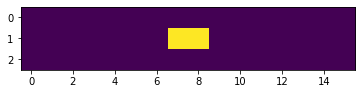

In [50]:
if night_only_obs1=='y'and night_only_obs2=='y':
    print(f'Night only observation for BOTH Observatory {obs1.name.upper()} and {obs2.name.upper()}')
    
    dk={'datetimes':dt,'night_obs1':xc,'night_obs2':cc,
        'obs1_airmass':masked_airmass_obs1,'obs2_airmass':masked_airmass_obs2}
    
    df1=pd.DataFrame(data=dk)
    
    df=df1.round(3 )# Rounding up values 
     # Dropping NaN values but maintaining indexes in case there are NANs

    df=df.dropna()#Checking the dataframe
    df.reset_index(drop=True, inplace=True)
    #print(df)

    covis_list=(df[df['obs1_airmass'].between(low_airmasslim,high_airmasslim) & df['obs2_airmass'].between(low_airmasslim,high_airmasslim)])
   

    if len(covis_list)==0 or len(df)==0:
        mins=0
        print(f'{Fore.RED}No Co-Vis:Total time co-observable for {target_coord.ra.deg} and {target_coord.dec.deg} in minutes: {mins} mins{Style.RESET_ALL}')

    else:   
        com_vals=np.array([(df['night_obs1'] == True) & (df['night_obs2'] == True)&df['obs1_airmass'].between(low_airmasslim,high_airmasslim) & df['obs2_airmass'].between(low_airmasslim,high_airmasslim)])
        com_vals
        fb=com_vals[0][:]
        p=int((len(fb))*0.2)
        nit=np.zeros(p,dtype=bool)

        yy=np.append(nit,fb) #Adding false to the beginning of the list 
        tt=np.append(yy,nit)
        gg=1*tt #converting to binary
        ff=np.zeros(len(gg)) #Generating zeros
        vls=np.array([ff,tt,ff])

        vls=vls.astype(np.uint8)
        (thresh, gray) = cv2.threshold(vls, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        ret, labels = cv2.connectedComponents(gray)
        plt.imshow(vls)
        k=np.unique(labels, return_counts=True)

        cb=k[1][1:]
        if len(cb)==0:
            fullmins=0
            print(f'{Fore.RED}No Co-Vis time for ra={target_coord.ra.deg} and dec={target_coord.dec.deg} Co-vis time: {fullmins} mins{Style.RESET_ALL}')

        else: 

            cvs=[]
            for i in (cb):
                cvs.append((time_interval*i))
                bgr_covis=np.max(cvs)
                total_covis=sum(cvs)

            print(f'{Fore.GREEN}Mulitiple ranges of Co-Vis time for ra={target_coord.ra.deg} and dec={target_coord.dec.deg} in minutes: {total_covis} mins{Style.RESET_ALL}')  
#########################################################################################


elif night_only_obs1=='y'and night_only_obs2=='n':
    print(f'Night only observation for {obs1.name.upper()} observatory only')
    
    dk={'datetimes':dt,'night_obs1':xc,'obs1_airmass':masked_airmass_obs1,'obs2_airmass':masked_airmass_obs2}
    df1=pd.DataFrame(data=dk)
    
    df=df1.round(3 )# Rounding up values 
    
    df=df.dropna()
    df.reset_index(drop=True, inplace=True)
    print(df)

    covis_list=(df[df['obs1_airmass'].between(low_airmasslim,high_airmasslim) & df['obs2_airmass'].between(low_airmasslim,high_airmasslim)])
   

    if len(covis_list)==0 or len(df)==0:
        mins=0
        print(f'{Fore.RED}No Co-Vis:Total time co-observable for {target_coord.ra.deg} and {target_coord.dec.deg} in minutes: {mins} mins{Style.RESET_ALL}')

    else:   
        com_vals=np.array([(df['night_obs1'] == True) &df['obs1_airmass'].between(low_airmasslim,high_airmasslim) & df['obs2_airmass'].between(low_airmasslim,high_airmasslim)])
        com_vals
        fb=com_vals[0][:]
        p=int((len(fb))*0.2)
        nit=np.zeros(p,dtype=bool)

        yy=np.append(nit,fb) #Adding false to the beginning of the list 
        tt=np.append(yy,nit)
        gg=1*tt #converting to binary
        ff=np.zeros(len(gg)) #Generating zeros
        vls=np.array([ff,tt,ff])

        vls=vls.astype(np.uint8)
        (thresh, gray) = cv2.threshold(vls, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        ret, labels = cv2.connectedComponents(gray)
        plt.imshow(vls)
        k=np.unique(labels, return_counts=True)

        cb=k[1][1:]
        if len(cb)==0:
            fullmins=0
            print(f'{Fore.RED}No Co-Vis time for ra={target_coord.ra.deg} and dec={target_coord.dec.deg} Co-vis time: {fullmins} mins{Style.RESET_ALL}')

        else: 

            cvs=[]
            for i in (cb):
                cvs.append((time_interval*i))
                bgr_covis=np.max(cvs)
                total_covis=sum(cvs)

            print(f'{Fore.GREEN}Mulitiple ranges of Co-Vis time for ra={target_coord.ra.deg} and dec={target_coord.dec.deg} in minutes: {total_covis} mins{Style.RESET_ALL}')  

####################################################################################################
        
elif night_only_obs1=='n'and night_only_obs2=='y':
    
    print(f'Night only observation for {obs2.name.upper()} observatory only')
    
    dk={'datetimes':dt,'night_obs2':cc,'obs1_airmass':masked_airmass_obs1,'obs2_airmass':masked_airmass_obs2}
    df1=pd.DataFrame(data=dk)
    
    df=df1.round(3 )# Rounding up values 
     # Dropping NaN values but maintaining indexes in case there are NANs

    df=df.dropna()#Checking the dataframe
    df.reset_index(drop=True, inplace=True)
    #print(df)

    covis_list=(df[df['obs1_airmass'].between(low_airmasslim,high_airmasslim) & df['obs2_airmass'].between(low_airmasslim,high_airmasslim)])
   

    if len(covis_list)==0 or len(df)==0:
        mins=0
        print(f'{Fore.RED}No Co-Vis:Total time co-observable for {target_coord.ra.deg} and {target_coord.dec.deg} in minutes: {mins} mins{Style.RESET_ALL}')

    else:   
        com_vals=np.array([(df['night_obs2'] == True)&df['obs1_airmass'].between(low_airmasslim,high_airmasslim) & df['obs2_airmass'].between(low_airmasslim,high_airmasslim)])
        com_vals
        fb=com_vals[0][:]
        p=int((len(fb))*0.2)
        nit=np.zeros(p,dtype=bool)

        yy=np.append(nit,fb) #Adding false to the beginning of the list 
        tt=np.append(yy,nit)
        gg=1*tt #converting to binary
        ff=np.zeros(len(gg)) #Generating zeros
        vls=np.array([ff,tt,ff])

        vls=vls.astype(np.uint8)
        (thresh, gray) = cv2.threshold(vls, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        ret, labels = cv2.connectedComponents(gray)
        plt.imshow(vls)
        k=np.unique(labels, return_counts=True)

        cb=k[1][1:]
        if len(cb)==0:
            fullmins=0
            print(f'{Fore.RED}No Co-Vis time for ra={target_coord.ra.deg} and dec={target_coord.dec.deg} Co-vis time: {fullmins} mins{Style.RESET_ALL}')

        else: 

            cvs=[]
            for i in (cb):
                cvs.append((time_interval*i))
                bgr_covis=np.max(cvs)
                total_covis=sum(cvs)

            print(f'{Fore.GREEN}Mulitiple ranges of Co-Vis time for ra={target_coord.ra.deg} and dec={target_coord.dec.deg} in minutes: {total_covis} mins{Style.RESET_ALL}') 
    
    
elif night_only_obs1=='n'and night_only_obs2=='n':
    print(f'Night only observation not required')
    dk={'datetimes':dt,'obs1_airmass':masked_airmass_obs1,'obs2_airmass':masked_airmass_obs2}
    df1=pd.DataFrame(data=dk)
    
    df=df1.round(3 )# Rounding up values 
     # Dropping NaN values but maintaining indexes in case there are NANs

    df=df.dropna()#Checking the dataframe
    df.reset_index(drop=True, inplace=True)
    #print(df)

    covis_list=(df[df['obs1_airmass'].between(low_airmasslim,high_airmasslim) & df['obs2_airmass'].between(low_airmasslim,high_airmasslim)])
   

    if len(covis_list)==0 or len(df)==0:
        mins=0
        print(f'{Fore.RED}No Co-Vis:Total time co-observable for {target_coord.ra.deg} and {target_coord.dec.deg} in minutes: {mins} mins{Style.RESET_ALL}')

    else:   
        com_vals=np.array([df['obs1_airmass'].between(low_airmasslim,high_airmasslim) & df['obs2_airmass'].between(low_airmasslim,high_airmasslim)])
        com_vals
        fb=com_vals[0][:]
        p=int((len(fb))*0.2)
        nit=np.zeros(p,dtype=bool)

        yy=np.append(nit,fb) #Adding false to the beginning of the list 
        tt=np.append(yy,nit)
        gg=1*tt #converting to binary
        ff=np.zeros(len(gg)) #Generating zeros
        vls=np.array([ff,tt,ff])

        vls=vls.astype(np.uint8)
        (thresh, gray) = cv2.threshold(vls, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        ret, labels = cv2.connectedComponents(gray)
        plt.imshow(vls)
        k=np.unique(labels, return_counts=True)

        cb=k[1][1:]
        if len(cb)==0:
            fullmins=0
            print(f'{Fore.RED}No Co-Vis time for ra={target_coord.ra.deg} and dec={target_coord.dec.deg} Co-vis time: {fullmins} mins{Style.RESET_ALL}')

        else: 

            cvs=[]
            for i in (cb):
                cvs.append((time_interval*i))
                bgr_covis=np.max(cvs)
                total_covis=sum(cvs)

            print(f'{Fore.GREEN}Mulitiple ranges of Co-Vis time for ra={target_coord.ra.deg} and dec={target_coord.dec.deg} in minutes: {total_covis} mins{Style.RESET_ALL}') 


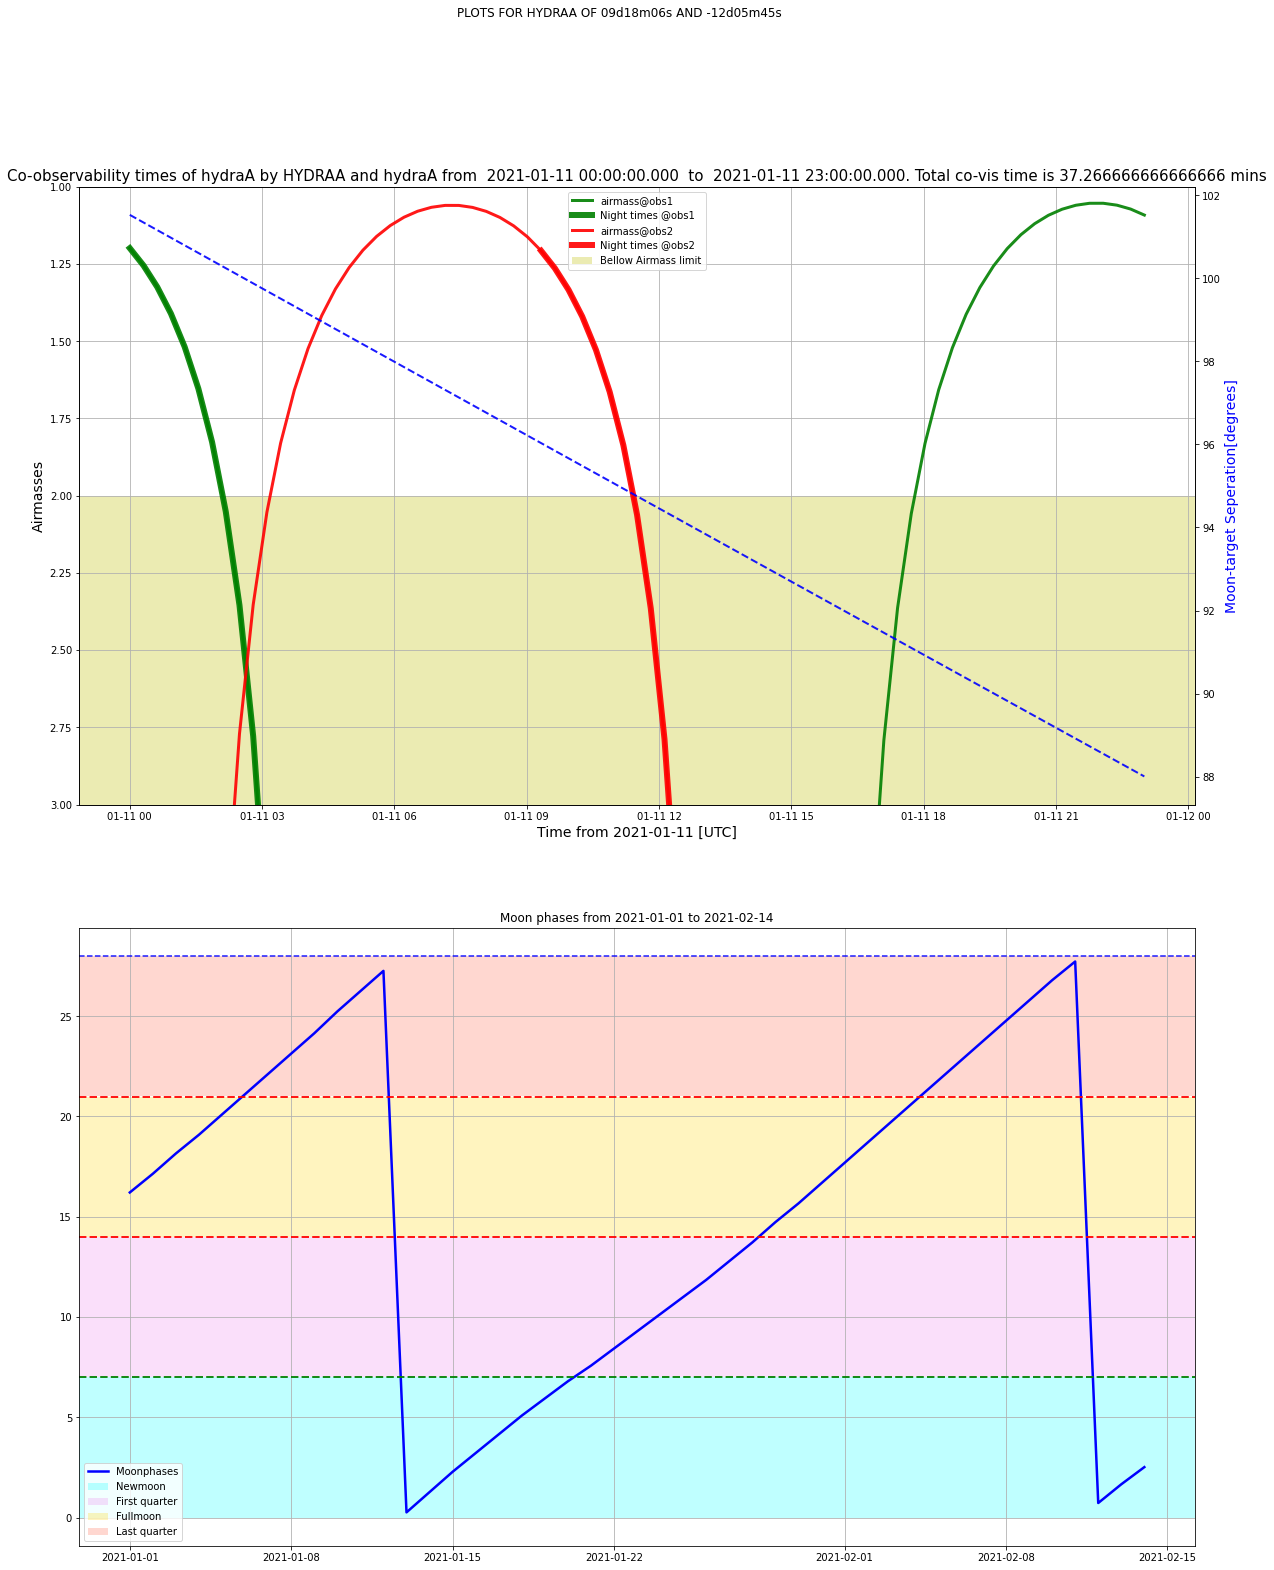

In [58]:
fig, (ax, ax2) = plt.subplots(2,figsize=(20, 25))


#ax.set_figure(figsize=(15,8))

fig.suptitle(f'PLOTS FOR {source_name.upper()} OF {ra} AND {dec}')

ax.set_title(f"Co-observability times of {source_name} by {target.name.upper()} and {target.name} from  {start_date}  to "\
           
         f" {end_date}. Total co-vis time is {total_covis} mins",fontsize=15)
ax.plot(dt_datetime, masked_airmass_obs1, label='airmass@obs1',color='g',linewidth=3, alpha=0.9)
ax.plot(dt_nobs1,night_ams_obs1,color='g',linewidth=6,alpha=0.9,label='Night times @obs1')#bolded regions for night time 
ax.plot(dt_datetime, masked_airmass_obs2, color='r', label='airmass@obs2',linewidth=3, alpha=0.9)
ax.plot(dt_nobs2,night_ams_obs2,color='r',linewidth=6,alpha=0.9,label='Night times @obs2')
ax.invert_yaxis()
ax.set_ylim([3,1])
ax.set_ylabel('Airmasses', color='k',fontsize=14)
ax.set_xlabel("Time from {0} [UTC]".format(min(dt_datetime).date()),fontsize=14)

ax3 = ax.twinx()
ax.axhspan(3, 2, facecolor='y', alpha=0.3,label='Bellow Airmass limit')
ax3.plot(dt_datetime, sep, color='b',linestyle='--', label='moon_sep',linewidth=2, alpha=0.9)
ax.legend(loc='best',prop={'size': 10})
ax3.set_ylabel('Moon-target Seperation[degrees]',color='b',fontsize=14)
ax.grid()



ax2.plot(dates,moonphases,linewidth=2.5,color='b',label='Moonphases')
ax2.axhline(y=6.99,color='g',linestyle='--',linewidth=2,alpha=0.9)
ax2.axhline(y = 14, color = 'r', linestyle = '--',linewidth=2,alpha=0.9) 
ax2.axhline(y= 20.99, color = 'r', linestyle = '--',linewidth=2,alpha=0.9) 
ax2.axhline(y = 27.99, color = 'b', linestyle = '--',alpha=0.9)
#fills
ax2.axhspan(0, 6.99, facecolor='cyan', alpha=0.25,label='Newmoon')
ax2.axhspan(7, 13.99, facecolor='violet', alpha=0.25,label='First quarter')
ax2.axhspan(14, 20.99, facecolor='gold', alpha=0.25,label='Fullmoon')
ax2.axhspan(21, 27.99, facecolor='tomato', alpha=0.25,label='Last quarter')
ax2.grid()
ax2.set_title('Moon phases from '+str(dates[0])+' to '+str(dates[-1])+'')
ax2.legend(loc='best',facecolor="w")
plt.savefig(save_location+f"Co-vis times of {obs1.name.upper()} and {obs2.name} from  {start_date}  to "\
          
          f" {end_date}  .png")

                  datetimes  night_obs1  night_obs2  obs1_airmass  \
0   2021-01-11 00:55:56.757        True       False         1.411   
1   2021-01-11 01:14:35.676        True       False         1.518   
2   2021-01-11 01:33:14.595        True       False         1.653   
3   2021-01-11 01:51:53.514        True       False         1.826   
4   2021-01-11 02:10:32.432        True       False         2.052   
5   2021-01-11 02:29:11.351        True       False         2.355   
6   2021-01-11 02:47:50.270        True       False         2.779   
7   2021-01-11 03:06:29.189        True       False         3.410   
8   2021-01-11 03:25:08.108        True       False         4.436   
9   2021-01-11 03:43:47.027        True       False         6.377   
10  2021-01-11 04:02:25.946        True       False        11.384   
11  2021-01-11 04:21:04.865        True       False        52.678   

    obs2_airmass  
0         41.765  
1         10.867  
2          6.242  
3          4.385  
4      

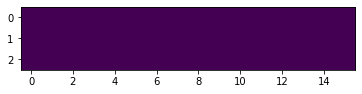

In [46]:

df1=pd.DataFrame(data=dk)
df=df1.round(3 )# Rounding up values 
 # Dropping NaN values but maintaining indexes in case there are NANs

df=df.dropna()#Checking the dataframe
df.reset_index(drop=True, inplace=True)
print(df)

covis_list=(df[df['obs1_airmass'].between(low_airmasslim,high_airmasslim) & df['obs2_airmass'].between(low_airmasslim,high_airmasslim)])
covis_list
com_vals=np.array([(df['night_obs1'] == True) & (df['night_obs2'] == True)&df['obs1_airmass'].between(low_airmasslim,high_airmasslim) & df['obs2_airmass'].between(low_airmasslim,high_airmasslim)])
com_vals
fb=com_vals[0][:]
p=int((len(fb))*0.2)
nit=np.zeros(p,dtype=bool)

yy=np.append(nit,fb) #Adding false to the beginning of the list 
tt=np.append(yy,nit)
gg=1*tt #converting to binary
ff=np.zeros(len(gg)) #Generating zeros
vls=np.array([ff,tt,ff])

vls=vls.astype(np.uint8)
(thresh, gray) = cv2.threshold(vls, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

ret, labels = cv2.connectedComponents(gray)
plt.imshow(vls)
k=np.unique(labels, return_counts=True)

cb=k[1][1:]
if len(cb)==0:
    fullmins=0
    print(f'{Fore.RED}No Co-Vis time for ra={target_coord.ra.deg} and dec={target_coord.dec.deg} Co-vis time: {fullmins} mins{Style.RESET_ALL}')
    
else: 
    
    cvs=[]
    for i in (cb):
        cvs.append((time_interval*i))
        bgr_covis=np.max(cvs)
        total_covis=sum(cvs)

    print(f'{Fore.GREEN}Mulitiple ranges of Co-Vis time for ra={target_coord.ra.deg} and dec={target_coord.dec.deg} in minutes: {total_covis} mins{Style.RESET_ALL}')

In [39]:

#Creating a dictionary for the dataframe
d={'datetimes':dt_datetime,'obs1_airmass':masked_airmass_obs1,'obs2_airmass':masked_airmass_obs2}

#Creating a dataframe
df1=pd.DataFrame(data=d)   
#print(df1)
df=df1.round(3 )# Rounding up values 
 # Dropping NaN values but maintaining indexes in case there are NANs

df=df.dropna()#Checking the dataframe
df.reset_index(drop=True, inplace=True)
df

,datetimes,obs1_airmass,obs2_airmass
0,2021-01-11 00:55:56.756757,1.411,41.765
1,2021-01-11 01:14:35.675676,1.518,10.867
2,2021-01-11 01:33:14.594595,1.653,6.242
3,2021-01-11 01:51:53.513514,1.826,4.385
4,2021-01-11 02:10:32.432432,2.052,3.389
5,2021-01-11 02:29:11.351351,2.355,2.771
6,2021-01-11 02:47:50.270270,2.779,2.353
7,2021-01-11 03:06:29.189189,3.410,2.054
8,2021-01-11 03:25:08.108108,4.436,1.830
9,2021-01-11 03:43:47.027027,6.377,1.658


In [17]:
covis_list=(df[df['obs1_airmass'].between(low_airmasslim,high_airmasslim) & df['obs2_airmass'].between(low_airmasslim,high_airmasslim)])
#covis_list

In [18]:
vals=np.array([df['obs1_airmass'].between(low_airmasslim,high_airmasslim) & df['obs2_airmass'].between(low_airmasslim,high_airmasslim)])
vals

array([[False, False, False, False, False,  True,  True, False, False,
        False, False, False]])

Mulitiple ranges of Co-Vis time for ra=9.301666666666668 and dec=-12.095833333333333 in minutes: 37.266666666666666 mins


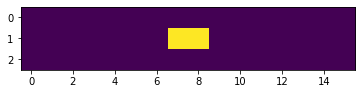

In [19]:
     
if len(covis_list)==0 or len(df)==0:
    #print(0)
    mins=0
    print(f'{Fore.RED}No Co-Vis:Total time co-observable for {target_coord.ra.deg} and {target_coord.dec.deg} in minutes: {mins} mins{Style.RESET_ALL}')

else:

    vals=np.array([df['obs1_airmass'].between(low_airmasslim,high_airmasslim) & df['obs2_airmass'].between(low_airmasslim,high_airmasslim)])

    v=vals[0][:]
    n=int((len(v))*0.2)
    plb=np.zeros(n,dtype=bool)
    vx=np.append(plb,v) #Adding false to the beginning of the list 
    vf=np.append(vx,plb)
    v_n=1*vf #converting to binary
    z=np.zeros(len(v_n)) #Generating zeros
    vz=np.array([z,vf,z])

    vz=vz.astype(np.uint8)
    (thresh, gray) = cv2.threshold(vz, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    ret, labels = cv2.connectedComponents(gray)
    plt.imshow(vz)
    k=np.unique(labels, return_counts=True)
    cb=k[1][1:]
    cvs=[]
    for i in (cb):
        cvs.append((time_interval*i))
    bgr_covis=np.max(cvs)
    total_covis=sum(cvs)
    
    print(f'{Fore.GREEN}Mulitiple ranges of Co-Vis time for ra={target_coord.ra.deg} and dec={target_coord.dec.deg} in minutes: {total_covis} mins{Style.RESET_ALL}')
         
    #plt.figure(figsize=(20,10))
    #plt.imshow(vz)


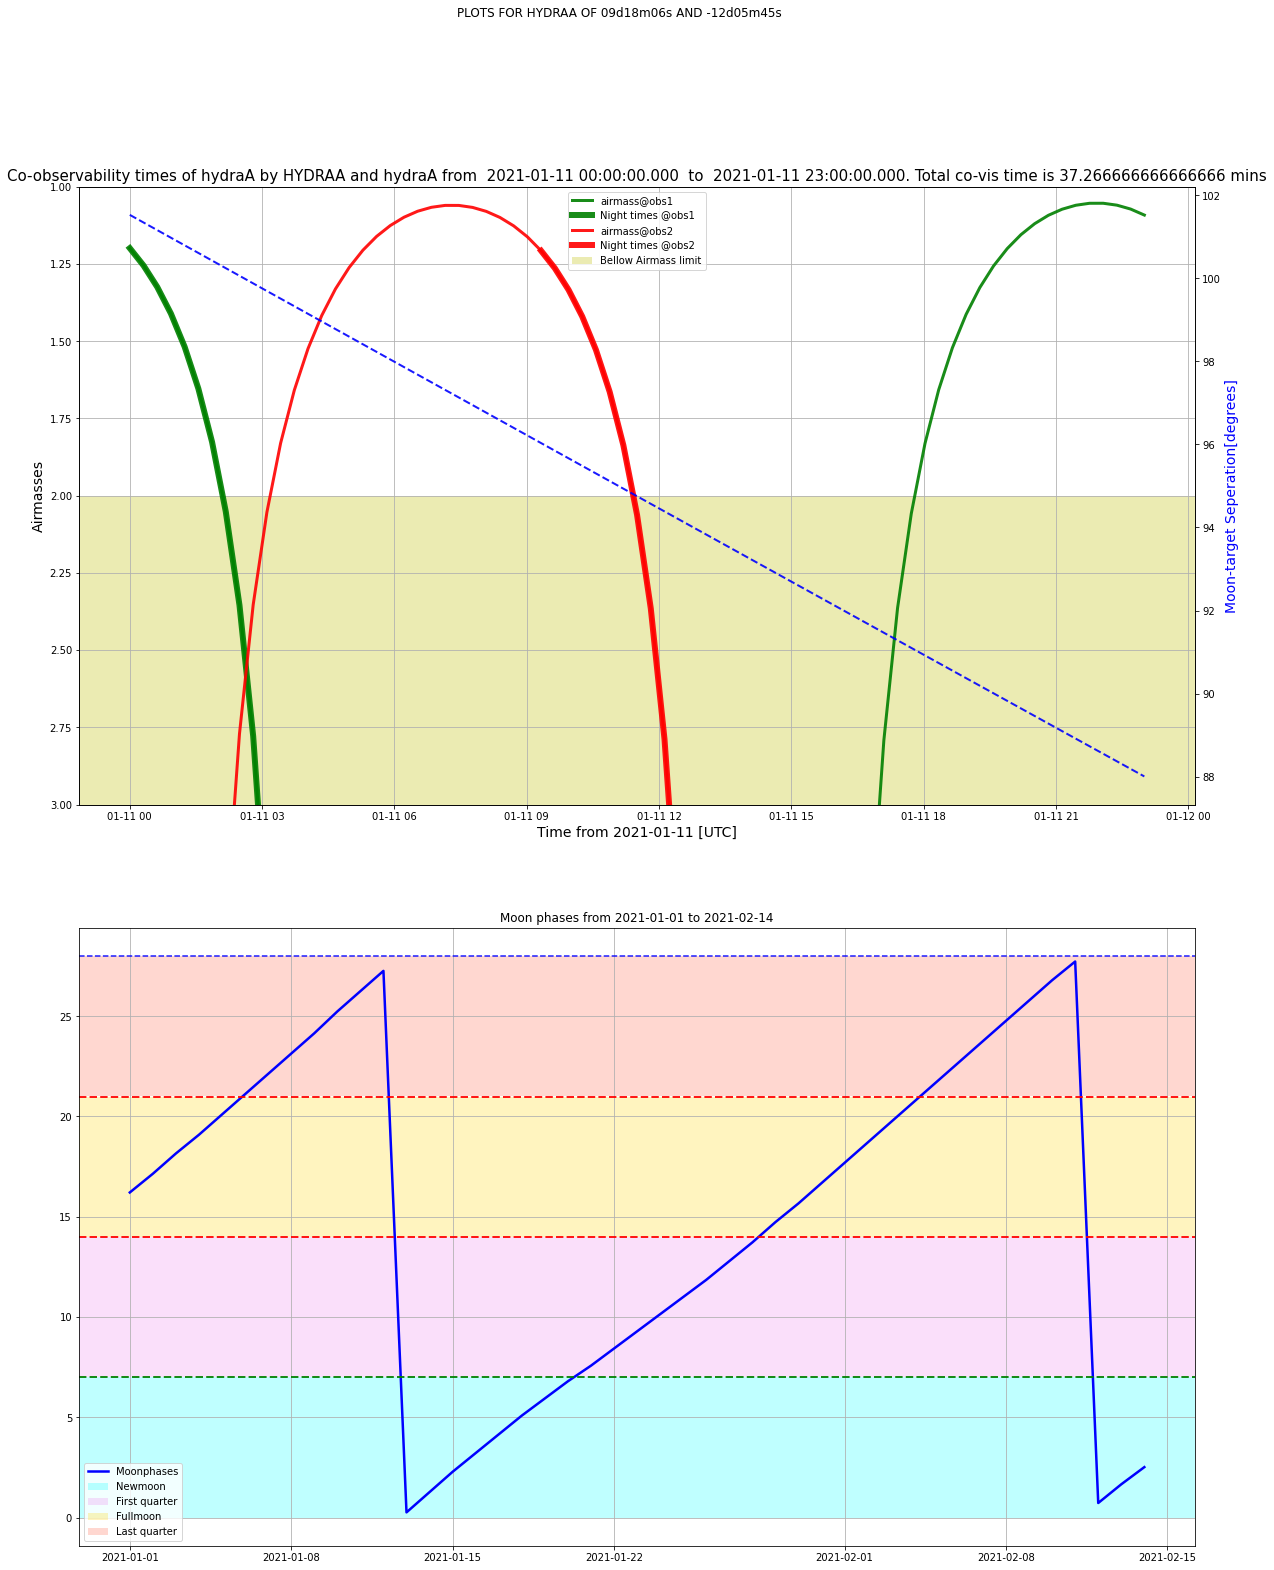

In [23]:
fig, (ax, ax2) = plt.subplots(2,figsize=(20, 25))


#ax.set_figure(figsize=(15,8))

fig.suptitle(f'PLOTS FOR {source_name.upper()} OF {ra} AND {dec}')

ax.set_title(f"Co-observability times of {source_name} by {target.name.upper()} and {target.name} from  {start_date}  to "\
           
         f" {end_date}. Total co-vis time is {total_covis} mins",fontsize=15)
ax.plot(dt_datetime, masked_airmass_obs1, label='airmass@obs1',color='g',linewidth=3, alpha=0.9)
ax.plot(dt_n,night_amsobs1,color='g',linewidth=6,alpha=0.9,label='Night times @obs1')#bolded regions for night time 
ax.plot(dt_datetime, masked_airmass_obs2, color='r', label='airmass@obs2',linewidth=3, alpha=0.9)
ax.plot(dt_nobs2,night_ams_obs2,color='r',linewidth=6,alpha=0.9,label='Night times @obs2')
ax.invert_yaxis()
ax.set_ylim([3,1])
ax.set_ylabel('Airmasses', color='k',fontsize=14)
ax.set_xlabel("Time from {0} [UTC]".format(min(dt_datetime).date()),fontsize=14)

ax3 = ax.twinx()
ax.axhspan(3, 2, facecolor='y', alpha=0.3,label='Bellow Airmass limit')
ax3.plot(dt_datetime, sep, color='b',linestyle='--', label='moon_sep',linewidth=2, alpha=0.9)
ax.legend(loc='best',prop={'size': 10})
ax3.set_ylabel('Moon-target Seperation[degrees]',color='b',fontsize=14)
ax.grid()









ax2.plot(dates,moonphases,linewidth=2.5,color='b',label='Moonphases')
ax2.axhline(y=6.99,color='g',linestyle='--',linewidth=2,alpha=0.9)
ax2.axhline(y = 14, color = 'r', linestyle = '--',linewidth=2,alpha=0.9) 
ax2.axhline(y= 20.99, color = 'r', linestyle = '--',linewidth=2,alpha=0.9) 
ax2.axhline(y = 27.99, color = 'b', linestyle = '--',alpha=0.9)
#fills
ax2.axhspan(0, 6.99, facecolor='cyan', alpha=0.25,label='Newmoon')
ax2.axhspan(7, 13.99, facecolor='violet', alpha=0.25,label='First quarter')
ax2.axhspan(14, 20.99, facecolor='gold', alpha=0.25,label='Fullmoon')
ax2.axhspan(21, 27.99, facecolor='tomato', alpha=0.25,label='Last quarter')
ax2.grid()
ax2.set_title('Moon phases from '+str(dates[0])+' to '+str(dates[-1])+'')
ax2.legend(loc='best',facecolor="w")
plt.savefig(save_location+f"Co-vis times of {obs1.name.upper()} and {obs2.name} from  {start_date}  to "\
          
          f" {end_date}  .png")